In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)
from itertools import product
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pickle
import joblib

### Load the data

In [2]:
period = 140

In [18]:
# keep all limbs has same amount of abnormal samples
data_normal = np.loadtxt('data_for_train.csv', delimiter=',')
RF_ab = np.load('RF_limb.npy')
LF_ab = np.load('LF_limb.npy')
LH_ab = np.load('LH_limb.npy')
RH_ab = np.load('RH_limb.npy')[period*3:,:]


In [50]:
RH_ab.shape[0] // period

30

In [20]:
data_for_predict = apply_saved_scalers(np.vstack((data_normal, RF_ab, LF_ab, LH_ab, RH_ab)))

### Load the model

#### ESN model

In [21]:
esn_rf, esn_lf, esn_lh, esn_rh = load_esn_models()

#### MLP model

In [22]:
model_tags = ["RF_Z", "RF_Y", "LF_Z", "LF_Y", "LH_Z", "LH_Y", "RH_Z", "RH_Y"]
models = load_named_models(MLP, model_tags, base_path="./Model/", device='cpu')

### Prediction

#### ESN prediction

In [27]:
# ESN prediction
rf_esn_prediction = esn_rf.predict(data_for_predict[:, 16:20])
lf_esn_prediction = esn_lf.predict(data_for_predict[:, 20:24])
lh_esn_prediction = esn_lh.predict(data_for_predict[:, 24:28])
rh_esn_prediction = esn_rh.predict(data_for_predict[:, 28:32])
# retrieve leading signal for MLP prediction
rf_leading, rf_behind = split_by_half_period(rf_esn_prediction,period,70,70)
lf_leading, lf_behind = split_by_half_period(lf_esn_prediction,period,70,70)
lh_leading, lh_behind = split_by_half_period(lh_esn_prediction,period,70,70)
rh_leading, rh_behind = split_by_half_period(rh_esn_prediction,period,70,70)

In [28]:
rf_predicted = esn_rf.predict(data_for_predict[:,16:20])
rf_target = data_for_predict[:,32:34]

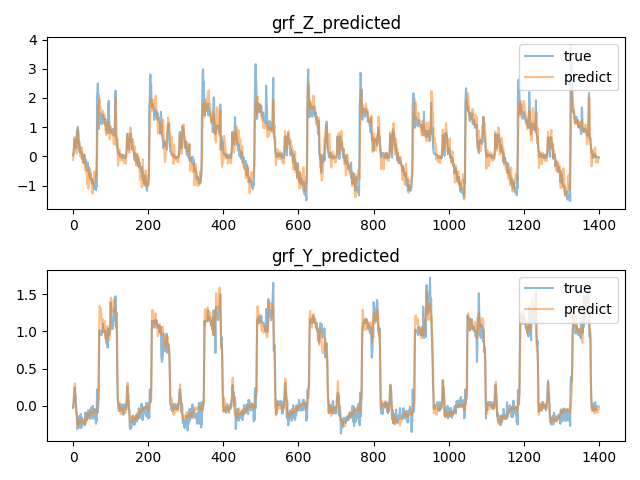

In [29]:
plot_grf_prediction(rf_target,rf_predicted,period*60,period*70)

In [32]:
# resplit to indiviual sample# select y to train as an example
'''Z'''
# rf
rf_in_z = reshape_to_samples(rf_leading[:,0])
# lf
lf_in_z = reshape_to_samples(lf_leading[:,0])
# lh
lh_in_z = reshape_to_samples(lh_leading[:,0])
# rh
rh_in_z = reshape_to_samples(rh_leading[:,0])

'''Y'''
# rf
rf_in_y = reshape_to_samples(rf_leading[:,1])
# lf
lf_in_y = reshape_to_samples(lf_leading[:,1])
# lh
lh_in_y = reshape_to_samples(lh_leading[:,1])
# rh
rh_in_y = reshape_to_samples(rh_leading[:,1])

#### MLP prediction

In [33]:
# rf signals 
RF_Z_latter_half = np.array([predict(x, models["RF_Z"]) for x in rf_in_z])
RF_Y_latter_half = np.array([predict(x, models["RF_Y"]) for x in rf_in_y])
# lf signals 
LF_Z_latter_half = np.array([predict(x, models["LF_Z"]) for x in lf_in_z])
LF_Y_latter_half = np.array([predict(x, models["LF_Y"]) for x in lf_in_y])
# lh signals 
LH_Z_latter_half = np.array([predict(x, models["LH_Z"]) for x in lh_in_z])
LH_Y_latter_half = np.array([predict(x, models["LH_Y"]) for x in lh_in_y])
# rh signals 
RH_Z_latter_half = np.array([predict(x, models["RH_Z"]) for x in rh_in_z])
RH_Y_latter_half = np.array([predict(x, models["RH_Y"]) for x in rh_in_y])

#### Combine the esn and mlp to get the final prediction

In [34]:
# Z signals
rf_prediction_z = np.concatenate((rf_in_z, RF_Z_latter_half), axis=1)
lf_prediction_z = np.concatenate((lf_in_z, LF_Z_latter_half), axis=1)
lh_prediction_z = np.concatenate((lh_in_z, LH_Z_latter_half), axis=1)
rh_prediction_z = np.concatenate((rh_in_z, RH_Z_latter_half), axis=1)
# Y signals
rf_prediction_y = np.concatenate((rf_in_y, RF_Y_latter_half), axis=1)
lf_prediction_y = np.concatenate((lf_in_y, LF_Y_latter_half), axis=1)
lh_prediction_y = np.concatenate((lh_in_y, LH_Y_latter_half), axis=1)
rh_prediction_y = np.concatenate((rh_in_y, RH_Y_latter_half), axis=1)

In [38]:
data_for_predict.shape

(24780, 40)

#### Plot to see res

In [40]:
# Extract target and split
rf_target = split_sequential_data(data_for_predict[:, 32:34], period)
lf_target = split_sequential_data(data_for_predict[:, 34:36], period)
lh_target = split_sequential_data(data_for_predict[:, 36:38], period)
rh_target = split_sequential_data(data_for_predict[:, 38:40], period)

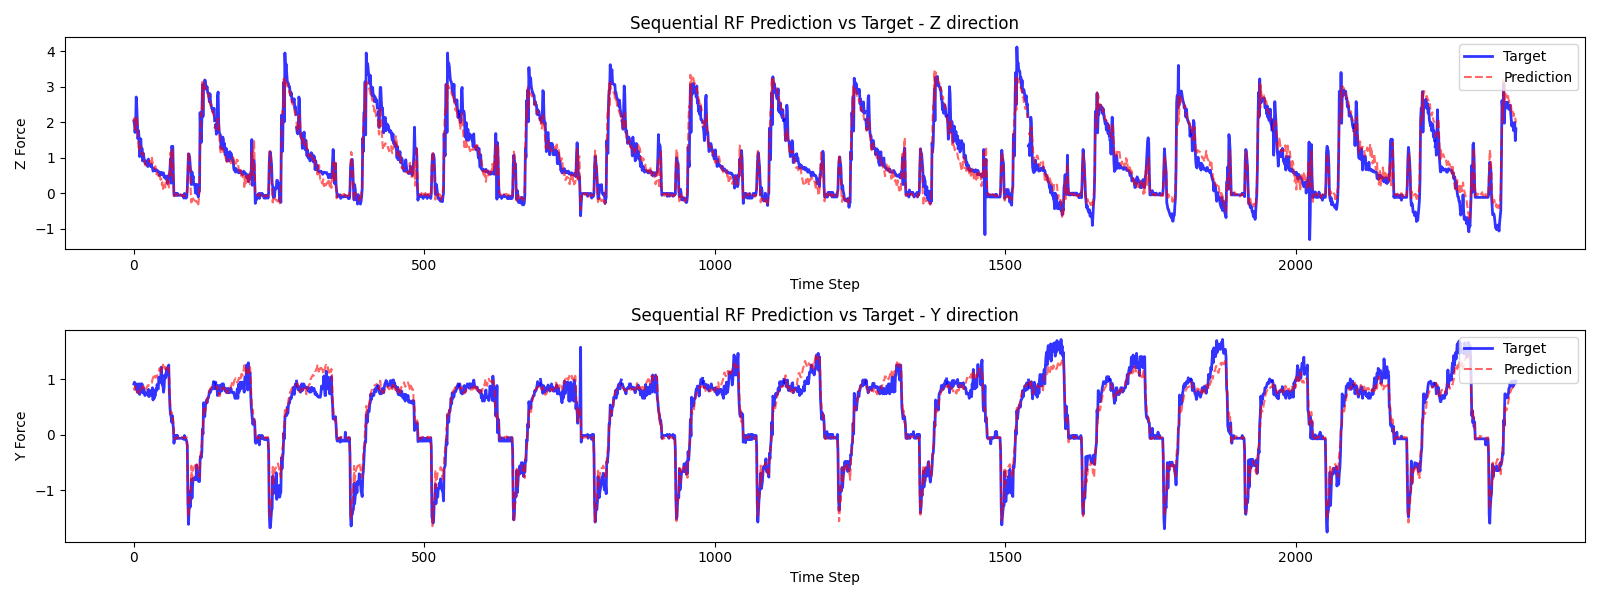

In [79]:
plot_rf_predictions_sequential(rh_prediction_z, rh_prediction_y, rh_target, 160, )

#### Calculate the error and remove outliers

In [ ]:
# Z error
rf_error_z = compute_segment_means(np.sum(np.abs(rf_prediction_z), axis=1))
lf_error_z = compute_segment_means(np.sum(np.abs(lf_prediction_z), axis=1))
lh_error_z = compute_segment_means(np.sum(np.abs(lh_prediction_z), axis=1))
rh_error_z = compute_segment_means(np.sum(np.abs(rh_prediction_z), axis=1))

# Y error
rf_error_y = compute_segment_means(np.sum(np.abs(rf_prediction_y), axis=1))
lf_error_y = compute_segment_means(np.sum(np.abs(lf_prediction_y), axis=1))
lh_error_y = compute_segment_means(np.sum(np.abs(lh_prediction_y), axis=1))
rh_error_y = compute_segment_means(np.sum(np.abs(rh_prediction_y), axis=1))
# z
error_z_list = [rf_error_z, lf_error_z, lh_error_z, rh_error_z]  
error_z = np.column_stack(error_z_list)  
# y
error_y_list = [rf_error_y, lf_error_y, lh_error_y, rh_error_y]  
error_y = np.column_stack(error_y_list)  


In [88]:
compute_segment_means(rf_error_z)

array([151.0827838 ,  99.59994812,  77.88462906, 112.95192132,
       110.68788377])

In [84]:
147-118+1

30

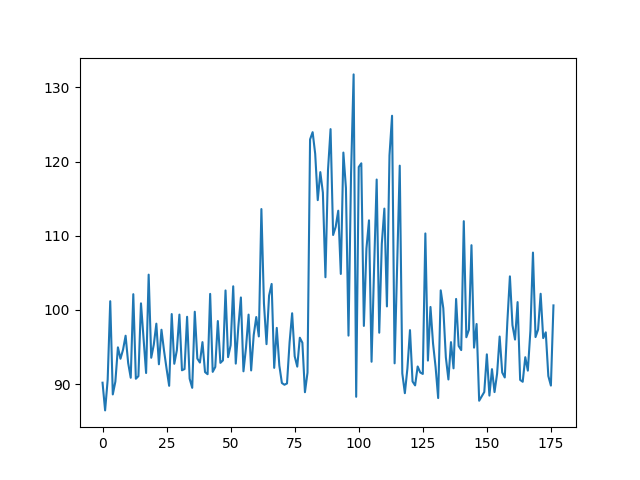

In [91]:
plt.close('all')
plt.plot(rh_error_y)


#### Utility

In [87]:
def compute_segment_means(data):
    """
    Compute the mean of specific segments of a 1D array.

    Parameters:
    - data: np.ndarray of shape (n,)

    Returns:
    - list of means for each specified segment
    """
    means = [
        np.mean(data[0:52]),     # includes index 0 to 51
        np.mean(data[52:82]),    # includes index 52 to 81
        np.mean(data[82:118]),   # includes index 82 to 117
        np.mean(data[118:148]),  # includes index 118 to 147
        np.mean(data[147:])      # includes index 147 to end
    ]
    return np.array(means)

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size=70, hidden_size=32, output_size=70):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)
def load_named_models(model_class, model_tags, base_path="./", device='cpu'):
    """
    Load multiple named models (e.g., MLP_RF_Z.pth) into a dictionary.

    Parameters:
    - model_class: class definition of the model (e.g., MLP)
    - model_tags: list of tags like ["RF_Z", "RF_Y", "LF_Z", "LF_Y"]
    - base_path: folder where model files are located
    - device: 'cpu' or 'cuda'

    Returns:
    - Dictionary of loaded models, e.g., models["RF_Z"] -> model
    """
    models = {}
    for tag in model_tags:
        model = model_class()
        path = f"{base_path}MLP_{tag}.pth"
        state_dict = torch.load(path, map_location=torch.device(device))
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        models[tag] = model
    return models
def predict(input_array, model, scaler_X=None, scaler_Y=None):
    model.eval()
    x = input_array.reshape(1, -1)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        y_tensor = model(x_tensor)
    y = y_tensor.cpu().numpy().squeeze()
   
    return y

In [14]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)
        
def load_esn_models(model_dir='./Model'):
    model_names = ['RF', 'LF', 'LH', 'RH']
    esn_models = {}

    for name in model_names:
        file_path = f'{model_dir}/esn_{name}.pkl'
        with open(file_path, 'rb') as f:
            esn_models[name] = pickle.load(f)

    return esn_models['RF'], esn_models['LF'], esn_models['LH'], esn_models['RH']

In [42]:

def plot_rf_predictions_sequential(rf_prediction_z, rf_prediction_y, rf_target, start_idx=1, end_idx=None):
    """
    Plot predicted and target RF signals for sequential samples between start_idx and end_idx.

    Parameters:
    - rf_prediction_z: np.ndarray of shape (n_samples, 140)
    - rf_prediction_y: np.ndarray of shape (n_samples, 140, 2)
    - rf_target: np.ndarray of shape (n_samples, 140, 2)
    - start_idx: int, starting sample index (default is 1)
    - end_idx: int or None, ending sample index (default is last sample)
    """
    if end_idx is None:
        end_idx = rf_prediction_z.shape[0]
    
    indices = range(start_idx, end_idx)

    plt.figure(figsize=(16, 6))

    # Upper subplot: Z direction
    plt.subplot(2, 1, 1)
    for i, idx in enumerate(indices):
        start = i * 140
        end = (i + 1) * 140
        plt.plot(np.arange(start, end), rf_target[idx, :, 0], color='blue', linewidth=2, alpha=0.8)
        plt.plot(np.arange(start, end), rf_prediction_z[idx], color='red', linestyle='--', alpha=0.6)
    plt.title('Sequential RF Prediction vs Target - Z direction')
    plt.xlabel('Time Step')
    plt.ylabel('Z Force')
    plt.legend(['Target', 'Prediction'], loc='upper right')

    # Lower subplot: Y direction
    plt.subplot(2, 1, 2)
    for i, idx in enumerate(indices):
        start = i * 140
        end = (i + 1) * 140
        plt.plot(np.arange(start, end), rf_target[idx, :, 1], color='blue', linewidth=2, alpha=0.8)
        plt.plot(np.arange(start, end), rf_prediction_y[idx], color='red', linestyle='--', alpha=0.6)
    plt.title('Sequential RF Prediction vs Target - Y direction')
    plt.xlabel('Time Step')
    plt.ylabel('Y Force')
    plt.legend(['Target', 'Prediction'], loc='upper right')

    plt.tight_layout()
    plt.show()


In [17]:
def apply_saved_scalers(data, scaler_dir='./Model', slices=[(16, 20), (20, 24), (24, 28), (28, 32)]):
    """
    Apply previously saved scalers to the corresponding column slices of the input data.

    Parameters:
    - data: np.ndarray of shape (n_samples, n_features)
    - scaler_dir: directory where scalers are saved
    - slices: list of (start, end) column indices for each scaler

    Returns:
    - scaled_data: np.ndarray with the same shape as input, scaled
    """
    scaled_data = data.copy()
    for idx, (start, end) in enumerate(slices):
        scaler_path = os.path.join(scaler_dir, f'scaler_{idx}.save')
        scaler = joblib.load(scaler_path)
        scaled_data[:, start:end] = scaler.transform(scaled_data[:, start:end])
    return scaled_data

In [25]:
def reshape_to_samples(data, sample_length=70):
    n = len(data)
    num_samples = n // sample_length  # Number of complete samples
    trimmed_data = data[:num_samples * sample_length]
    reshaped = trimmed_data.reshape((num_samples, sample_length))
    return reshaped

In [26]:
def split_by_half_period(data, period, front_half_period, back_half_period):
    n = data.shape[0] // period
    set_out1 = []
    set_out2 = []

    for i in range(n):
        start = i * period
        set_out1.append(data[start : start + front_half_period, :])
        set_out2.append(data[start + period - back_half_period : start + period, :])

    return np.vstack(set_out1), np.vstack(set_out2)

def split_signal_halves(data_in):
    """
    Splits a 3D array into two halves along the second dimension.

    Parameters:
    - data_in: np.ndarray of shape (n_samples, time_steps, channels)

    Returns:
    - data_leading: np.ndarray of shape (n_samples, time_steps//2, channels)
    - data_behind: np.ndarray of shape (n_samples, time_steps//2, channels)
    """
    midpoint = data_in.shape[1] // 2
    data_leading = data_in[:, :midpoint, :]
    data_behind = data_in[:, midpoint:, :]
    return data_leading, data_behind

In [39]:
def split_sequential_data(data, period):
    """
    Splits the input data into sequential chunks based on the specified period.

    Parameters:
    - data: np.ndarray of shape (n_samples, n_features)
    - period: int, the number of time steps per sequence

    Returns:
    - data_chunks: np.ndarray of shape (n_sequences, period, n_features)
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]
    n_sequences = n_samples // period

    # Trim data to full sequences only
    trimmed_data = data[:n_sequences * period]

    # Reshape into (n_sequences, period, n_features)
    data_chunks = trimmed_data.reshape(n_sequences, period, n_features)

    return data_chunks